In [1]:
import os
# import re
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from typing import List, Optional
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from typing import Dict, Tuple
import pm4py
from sklearn.model_selection import train_test_split

from package.processtransformer import constants
from package.processtransformer.models import transformer
from package.processtransformer.data.loader import LogsDataLoader
from package.processtransformer.data.processor import LogsDataProcessor
from package.processtransformer.constants import Task, Feature_Type, Target


# Initialize data dir, if not exists
if not os.path.exists("datasets"): 
    os.mkdir("datasets")

# Task: Next Activity

In [25]:
class pipeline:
    
    def __init__(self, dataset_name: str, filepath: str, columns: List[str], additional_columns: Optional[Dict[Feature_Type, List[str]]],
                 datetime_format: str, task: Task, model_learning_rate: float, model_epochs: int, model_num_layers: int,
                 input_columns: List[str], target_columns: Dict[str, Target] ):
        self.dataset_name: str = dataset_name
        self.filepath: str = filepath
        self.columns: List[str] = columns
        self.additional_columns: Optional[Dict[Feature_Type, List[str]]] = additional_columns
        self.datetime_format: str = datetime_format
        self.task: Task = task
        self.model_learning_rate: float = model_learning_rate
        self.model_epochs: int = model_epochs
        self.model_num_layers: int = model_num_layers
        
        self.target_columns: Dict[str, Target] = target_columns
        for target_col in target_columns.keys():
            if target_col == columns[1]:
                self.target_columns["concept_name"] = self.target_columns.pop(target_col)
                break
                
        self.input_columns: List[str] = input_columns
        for idx, input_col in enumerate(input_columns):
            if input_col == columns[1]:
                self.input_columns[idx] = "concept_name"
                break
        
        # self._model_id: str = (
        #     f"{dataset_name}"
        #     f"##{'#'.join(self.columns)}"
        #     f"##{'#'.join(self.additional_columns)}"
        #     f"##{'#'.join(self.task.value)}"
        #     f"##{self.model_learning_rate}"
        #     f"##{self.model_epochs}"
        #     f"##{self.model_num_layers}")
        
        
    def __str__(self):
        return (
            f"dataset_name: '{self.dataset_name}'\n"
            f"filepath: '{self.filepath}'\n"
            f"columns: '{self.columns}'\n"
            f"additional_columns: '{self.additional_columns}'\n"
            f"datetime_format: '{self.datetime_format}'\n"
            f"task: '{self.task.value}'\n"
            f"Model learning rate: '{self.model_learning_rate}'\n"
            f"Model Epochs: '{self.model_epochs}'\n"
            f"Number of Transformer Layers in Model: '{self.model_num_layers}'\n"
            f"Target columns: '{self.target_columns}'\n"
            f"Input columns: '{self.input_columns}'\n")
        
    
    def safe_as_csv(self):
        dir_path = os.path.join( "datasets", self.dataset_name )
        os.makedirs(dir_path, exist_ok=True)
        file_path = os.path.join( dir_path, self.filepath )
        
        
        if file_path.endswith('.xes'):
            print("Converting xes to csv file")
            df = pm4py.convert_to_dataframe(pm4py.read_xes(file_path)).astype(str)
            df.to_csv(file_path.replace(".xes", ".csv"), index=False)
        elif file_path.endswith('.csv'):
            print("Input file already has csv format")
            
            
        
        
    
    # preprocess the event log and save the train-test split as csv files
    def preprocess_log(self) -> List[int]:
        data_processor = LogsDataProcessor(
            name=self.dataset_name,
            filepath=self.filepath,
            columns=self.columns,
            additional_columns=self.additional_columns,  # Add all additional columns here, first all categorical, then all numerical features
            datetime_format=self.datetime_format,
            pool=4
        )
        # Preprocess the event log and make train-test split
        data_processor.process_logs(task=self.task, sort_temporally=False)
        
        # TODO: Compute the number of unique classes in each categorical column
        # train_df = pd.read_csv(os.path.join("datasets", self.dataset_name, "processed", f"{self._preprocessing_id}_train.csv"))
        # num_classes_list = data_processor._compute_num_classes(train_df)
        
        # return num_classes_list
    
    
    # load the preprocessed train-test split from the csv files
    def load_data(self) -> Tuple [ LogsDataLoader, Dict[str, pd.DataFrame], Dict[str, pd.DataFrame], Dict[str, Dict[str, int]], Dict[Feature_Type, List[str]] ]:
        data_loader = LogsDataLoader(name=self.dataset_name, input_columns=self.input_columns, target_columns=self.target_columns)
        train_dfs, test_dfs, word_dicts, feature_type_dict = data_loader.load_data()
        return data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict
    
    
    def prepare_data( self, data_loader, dfs: Dict[str, pd.DataFrame] ) -> Tuple[ Dict[str, NDArray[np.float32]], Dict[str, NDArray[np.float32]], Dict[str, NDArray[np.float32]], int ]:
        print("Preparing data for task next_categorical...")
        
        # initialize token dicts
        x_token_dict, y_token_dict = {}, {}
        
        # loop over all feature dfs
        for idx, (feature, df) in enumerate(dfs.items()):
            
            if idx == 0:
                x_tokens, y_next_tokens, y_last_tokens, max_case_length = data_loader.prepare_data(df=df, max_case_length=True, shuffle=True)
            else:
                x_tokens, y_next_tokens, y_last_tokens = data_loader.prepare_data(df=df, shuffle=True)
            
            # update x_token_dict
            x_token_dict.update(x_tokens)
                
            # if feature is target column
            if feature in self.target_columns.keys():
                # update y_token_dict with next_feature as target
                if self.target_columns[feature] == Target.NEXT_FEATURE:
                    y_token_dict.update(y_next_tokens)
                # update y_token_dict with last_feature as target
                elif self.target_columns[feature] == Target.LAST_FEATURE:
                    y_token_dict.update(y_last_tokens)
                else: raise ValueError("Target type not defined")

        return x_token_dict, y_token_dict, max_case_length
    
    
    # Prepare data and train the model
    def train(self,
                feature_type_dict: Dict[Feature_Type, List[str]],
                train_token_dict_x: Dict[str, NDArray[np.float32]],
                train_token_dict_y: Dict[str, NDArray[np.float32]],
                word_dicts: Dict[str, Dict[str, int]],
                max_case_length: int,
                validation_split: float = 0.2  # Fraction of the training data to be used for validation
                ) -> tf.keras.Model:
        
        batch_size = 12
    
    
    
        # Define and compile the model
        model = transformer.get_model(
            input_columns=self.input_columns,
            target_columns=self.target_columns,
            word_dicts=word_dicts,
            max_case_length=max_case_length,
            feature_type_dict=feature_type_dict
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(self.model_learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        )
        
        
        ######################   Train-Validation Split    ######################
        # Prepare the data for validation
        first_key = next(iter(train_token_dict_x.keys()))
        n_samples = train_token_dict_x[first_key].shape[0]
        
        # Generate a train-validation split index
        indices = np.arange(n_samples)
        train_indices, val_indices = train_test_split(indices, test_size=validation_split, random_state=42)
        
        # Flatten the dictionary of inputs and targets for the train_test_split
        train_token_dict_x_split = {}
        val_token_dict_x_split = {}
        train_token_dict_y_split = {}
        val_token_dict_y_split = {}
        
        # Apply the split indices to all keys in train_token_dict_x
        for key, x_data in train_token_dict_x.items():
            train_token_dict_x_split[key] = x_data[train_indices]
            val_token_dict_x_split[key] = x_data[val_indices]
        
        # Apply the split indices to all keys in train_token_dict_y
        for key, y_data in train_token_dict_y.items():
            train_token_dict_y_split[key] = y_data[train_indices]
            val_token_dict_y_split[key] = y_data[val_indices]
        
        # EarlyStopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # You can also monitor 'val_sparse_categorical_accuracy'
            patience=3,  # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
            min_delta=0.001
        )
        ############################################
        
        # make model_specs_dir, if not exists
        model_specs_dir = os.path.join( "datasets", self.dataset_name, "model_specs" )
        os.makedirs(model_specs_dir, exist_ok=True)
        
        # EarlyStopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # You can also monitor 'val_sparse_categorical_accuracy'
            patience=3,  # Number of epochs with no improvement after which training will be stopped
            restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
        )
        
        # save model weights for highes accuracy
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join( model_specs_dir, "best_model.h5" ),
        save_weights_only=True,
        monitor="val_sparse_categorical_accuracy",
        mode="max", save_best_only=True)
        
            
        # Train the model
        history = model.fit(
                            {f"input_{key}": value for key, value in train_token_dict_x_split.items() if key in self.input_columns},
                            {f"output_{key}": value for key, value in train_token_dict_y_split.items() if key in self.target_columns.keys()},
                            validation_data=(
                                {f"input_{key}": value for key, value in val_token_dict_x_split.items() if key in self.input_columns},
                                {f"output_{key}": value for key, value in val_token_dict_y_split.items() if key in self.target_columns.keys()}
                            ),
                            epochs=self.model_epochs, batch_size=batch_size, shuffle=True,
                            callbacks=[early_stopping, model_checkpoint_callback])
            
        # Plot training loss
        self._plot_training_loss(history)
        return model
            
            
    # helper function for plotting the training loss
    def _plot_training_loss(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def evaluate(self, model, data_loader: LogsDataLoader, test_dfs: Dict[str, pd.DataFrame], max_case_length: int):
        print("Evaluating...")
        
        # Prepare lists to store evaluation metrics
        k, accuracies, fscores, precisions, recalls, weights = {}, {}, {}, {}, {}, {}
        for target_col in self.target_columns.keys():
            k.update({target_col: []})
            accuracies.update({target_col: []})
            fscores.update({target_col: []})
            precisions.update({target_col: []})
            recalls.update({target_col: []})
            weights.update({target_col: []})

        # Calculate total number of samples
        total_samples = len( list(test_dfs.values())[0] )

        # Iterate over all prefixes (k)
        for i in range(1, max_case_length+1):
            print( "Prefix length: " + str(i) )
            test_data_subsets = {}
            
            for key, df in test_dfs.items():
                filtered_df = df[df["Prefix Length"] == i]
                test_data_subsets.update({key: filtered_df})
                
            if len( test_data_subsets[self.input_columns[0]] ) > 0:
                
                # initialize token dicts
                x_token_dict, y_token_dict = {}, {}
                
                # Prepare the test data
                for feature, test_data_subset in test_data_subsets.items():
                        
                    # prepare data of subset batch
                    x_tokens, y_next_tokens, y_last_tokens = data_loader.prepare_data(df=test_data_subset)
                    
                    # update x_token_dict
                    x_token_dict.update(x_tokens)
                        
                    # if feature is a target feature
                    if feature in self.target_columns.keys():
                        # update y_token_dict with next_feature
                        if self.target_columns[feature] == Target.NEXT_FEATURE:
                            y_token_dict.update(y_next_tokens)
                        # update y_token_dict with next_feature
                        elif self.target_columns[feature] == Target.LAST_FEATURE:
                            y_token_dict.update(y_last_tokens)
                        else: raise ValueError("Target type not defined")
                
                # Filter x_token_dict and y_token_dict for input and target columns
                x_token_dict = {f"input_{key}": value for key, value in x_token_dict.items() if key in self.input_columns}
                y_token_dict = {f"output_{key}": value for key, value in y_token_dict.items() if key in self.target_columns.keys()}
                
                # Make predictions
                if len(self.target_columns) > 1:
                    result_dict = dict(zip( self.target_columns.keys(), [np.argmax(pred, axis=1) for pred in model.predict(x_token_dict)] ))
                else:
                    result_dict = dict(zip( self.target_columns.keys(), [np.argmax(model.predict(x_token_dict), axis=1)] ))
                # y_pred = np.argmax(model.predict(x_token_dict), axis=1)
                
                # Compute metrics
                for feature, result in result_dict.items():
                    
                    accuracy = metrics.accuracy_score(y_token_dict[f"output_{feature}"], result)
                    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_token_dict[f"output_{feature}"],
                                                                                           result, average="weighted", zero_division=0)
                    weight = len(test_data_subsets[feature]) / total_samples
                    
                    k[feature].append(i)
                    accuracies[feature].append(accuracy)
                    fscores[feature].append(fscore)
                    precisions[feature].append(precision)
                    recalls[feature].append(recall)
                    weights[feature].append(weight)

        for target_col in self.target_columns.keys():
            # Compute weighted mean metrics over all k
            weighted_accuracy = np.average(accuracies[target_col], weights=weights[target_col])
            weighted_fscore = np.average(fscores[target_col], weights=weights[target_col])
            weighted_precision = np.average(precisions[target_col], weights=weights[target_col])
            weighted_recall = np.average(recalls[target_col], weights=weights[target_col])
            # Append weighted mean metrics to the lists
            weights[target_col].append("")
            k[target_col].append("Weighted Mean")
            accuracies[target_col].append(weighted_accuracy)
            fscores[target_col].append(weighted_fscore)
            precisions[target_col].append(weighted_precision)
            recalls[target_col].append(weighted_recall)
            # Create a DataFrame to display the results
            print(f"Results for {target_col}")
            results_df = pd.DataFrame({
                'k': k[target_col],
                'weight': weights[target_col],
                'accuracy': accuracies[target_col],
                'fscore': fscores[target_col],
                'precision': precisions[target_col],
                'recall': recalls[target_col]
            })
            # Display the results
            print(results_df)

In [26]:
### Helper Functions ###

# helper function: do only preprocessing on data
def preprocess(additional_columns, input_columns, target_columns):
    # initialize pipeline with parameters
    pipe = pipeline(
        dataset_name = "helpdesk",
        filepath = "helpdesk.csv",
        columns = ["Case ID", "Activity", "Complete Timestamp"],
        additional_columns = additional_columns,
        datetime_format = "%Y-%m-%d %H:%M:%S.%f",
        task = constants.Task.NEXT_CATEGORICAL,
        model_learning_rate = 0.001,
        model_epochs = 1,
        model_num_layers = 1,
        target_columns=target_columns,
        input_columns=input_columns)  # Examples: "concept_name", "Resource"
    # preprocess data
    pipe.preprocess_log()


# helper function
def run(args):
    # initialize pipeline with parameters
    pipe = pipeline(**args)  # Examples: "concept:name", "Resource"

    # print parameters
    print(pipe)

    # preprocess data
    pipe.preprocess_log()

    # load data
    data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict = pipe.load_data()

    # prepare data
    train_token_dict_x, train_token_dict_y, max_case_length = pipe.prepare_data(data_loader, train_dfs)

    # train the model
    model = pipe.train(
                feature_type_dict = feature_type_dict,
                train_token_dict_x = train_token_dict_x,
                train_token_dict_y = train_token_dict_y,
                word_dicts = word_dicts,
                max_case_length = max_case_length
                )

    # evaluate the model
    pipe.evaluate(model, data_loader, test_dfs, max_case_length)
    print("")
    print("======================================")
    print("======================================")
    
    
# function for testing out code
def test(args):
    # initialize pipeline with parameters
    pipe = pipeline(**args)  # Examples: "concept:name", "Resource"

    # print parameters
    print(pipe)

    # preprocess data
    pipe.preprocess_log()

    # load data
    data_loader, train_dfs, test_dfs, word_dicts, feature_type_dict = pipe.load_data()

    # prepare data
    train_token_dict_x, train_token_dict_y, max_case_length = pipe.prepare_data(data_loader, train_dfs)

    # train the model
    model = pipe.train(
                feature_type_dict = feature_type_dict,
                train_token_dict_x = train_token_dict_x,
                train_token_dict_y = train_token_dict_y,
                word_dicts = word_dicts,
                max_case_length = max_case_length
                )

    return model, pipe, data_loader, test_dfs, max_case_length


dataset_name: 'helpdesk'
filepath: 'helpdesk.csv'
columns: '['Case ID', 'Activity', 'Complete Timestamp']'
additional_columns: '{<Feature_Type.CATEGORICAL: 'categorical'>: ['Resource']}'
datetime_format: '%Y-%m-%d %H:%M:%S.%f'
task: 'next_categorical'
Model learning rate: '0.001'
Model Epochs: '10'
Number of Transformer Layers in Model: '1'
Target columns: '{'concept_name': <Target.NEXT_FEATURE: 'next_feature'>}'
Input columns: '['concept_name', 'Resource']'

All processed files for current spec found. Preprocessing skipped.
Loading data from preprocessed train-test split...
['Resource', 'concept_name']
Preparing data for task next_categorical...
Creating model for task next_categorical...
Epoch 1/10
896/896 [==============================] - 55s 48ms/step - loss: 0.6989 - sparse_categorical_accuracy: 0.7858 - val_loss: 0.6473 - val_sparse_categorical_accuracy: 0.8010
Epoch 2/10
896/896 [==============================] - 43s 48ms/step - loss: 0.6221 - sparse_categorical_accuracy: 0.809

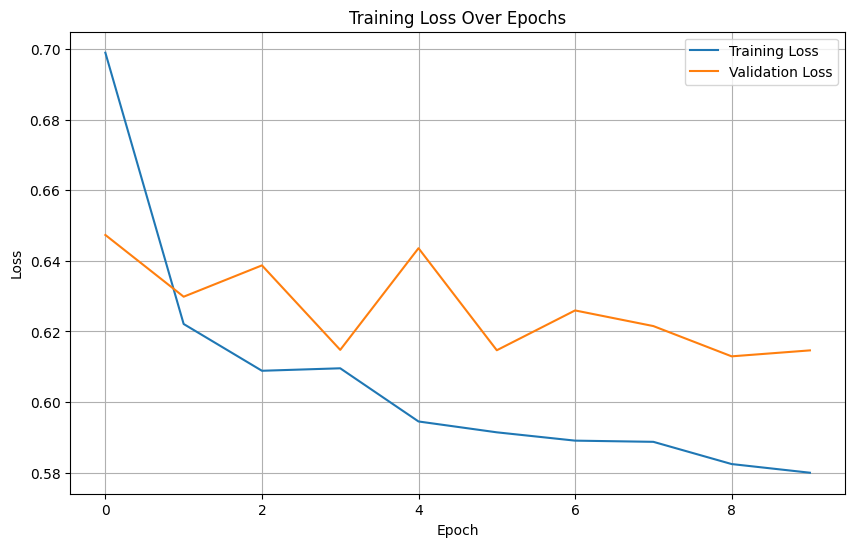

Evaluating...
Prefix length: 1
29/29 [==============================] - 3s 27ms/step
Prefix length: 2
29/29 [==============================] - 1s 27ms/step
Prefix length: 3
28/28 [==============================] - 1s 28ms/step
Prefix length: 4
12/12 [==============================] - 0s 21ms/step
Prefix length: 5
5/5 [==============================] - 0s 17ms/step
Prefix length: 6
3/3 [==============================] - 0s 17ms/step
Prefix length: 7
2/2 [==============================] - 0s 5ms/step
Prefix length: 8
1/1 [==============================] - 0s 184ms/step
Prefix length: 9
1/1 [==============================] - 0s 77ms/step
Prefix length: 10
1/1 [==============================] - 0s 79ms/step
Prefix length: 11
1/1 [==============================] - 0s 255ms/step
Prefix length: 12
1/1 [==============================] - 0s 87ms/step
Prefix length: 13
Prefix length: 14
Results for concept_name
                k    weight  accuracy    fscore  precision    recall
0               

In [28]:
args_helpdesk = {
        "dataset_name": "helpdesk",
        "filepath": "helpdesk.csv",
        "columns": ["Case ID", "Activity", "Complete Timestamp"],
        "additional_columns": {Feature_Type.CATEGORICAL: ["Resource"]},
        "datetime_format": "%Y-%m-%d %H:%M:%S.%f",
        "task": constants.Task.NEXT_CATEGORICAL,
        "model_learning_rate": 0.001,
        "model_epochs": 10,
        "model_num_layers": 1,
        "target_columns": {"concept_name": Target.NEXT_FEATURE},
        "input_columns": ["concept_name", "Resource"]
        }

args_sepsis = {
        "dataset_name": "sepsis",
        "filepath": "sepsis.xes",
        "columns": ["case:concept:name", "concept:name", "time:timestamp"],
        "additional_columns": {},
        "datetime_format": "%Y-%m-%d %H:%M:%S%z",
        "task": constants.Task.NEXT_CATEGORICAL,
        "model_learning_rate": 0.001,
        "model_epochs": 10,
        "model_num_layers": 1,
        "target_columns": ["concept_name"],
        "input_columns": ["concept_name"]
        }

args_bpi_2013 = {
        "dataset_name": "bpi_2013",
        "filepath": "BPI_Challenge_2013_incidents.xes",
        "columns": ["case:concept:name", "concept:name", "time:timestamp"],
        "additional_columns": {},
        "datetime_format": "%Y-%m-%dT%H:%M:%S%z",
        "task": constants.Task.NEXT_CATEGORICAL,
        "model_learning_rate": 0.001,
        "model_epochs": 10,
        "model_num_layers": 1,
        "target_columns": ["concept_name"],
        "input_columns": ["concept_name"]
        }

args_bpi_2015_1 = {
        "dataset_name": "bpi_2015_1",
        "filepath": "BPIC15_1.xes",
        "columns": ["case:concept:name", "concept:name", "time:timestamp"],
        "additional_columns": {},
        "datetime_format": "%Y-%m-%dT%H:%M:%S%z",
        "task": constants.Task.NEXT_CATEGORICAL,
        "model_learning_rate": 0.001,
        "model_epochs": 10,
        "model_num_layers": 1,
        "target_columns": ["concept_name"],
        "input_columns": ["concept_name"]
        }

run(args_helpdesk)


In [ ]:
# evaluate the model
# pipe.evaluate(model, data_loader, test_dfs, max_case_length)

In [ ]:
# run(additional_columns={Feature_Type.CATEGORICAL: ["Resource"]}, input_columns=["Activity", "Resource"], target_columns=["Activity"])

In [ ]:
# run(additional_columns={Feature_Type.CATEGORICAL: ["Resource"]}, input_columns=["Activity", "Resource"], target_columns=["Activity", "Resource"])